# Plot 2D Histograms of Data

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import pandas as pd
import numpy as np

import os
from pathlib2 import Path

In [27]:
# Allow LaTeX labels

latex = False
try:
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    latex = True
except Exception:
    print("LaTeX not used.")

In [33]:
# Helper. Based on SO answer: https://stackoverflow.com/a/18926541/9130036
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [28]:
# Load data
qcd = pd.read_pickle('data/qcd_100000_pt_250_500.pkl')
h = pd.read_pickle('data/higgs_100000_pt_250_500.pkl')

In [29]:
# Save dir
save_dir = 'plots/histograms/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
dir_path = Path(save_dir)

In [30]:
# Apply cuts
pt_min = 250
pt_max = 500

print("Length Higgs: {}".format(len(h)))
qcd = qcd[(pt_min < qcd['pt']) & (qcd['pt'] < pt_max)]
h = h[(pt_min < h['pt']) & (h['pt'] < pt_max)]

print("Length Higgs after cut: {}".format(len(h)))

# Choose labels
x_axis = 'mass'
y_axis = 'd2'

qcd = qcd[[x_axis, y_axis]]
h = h[[x_axis, y_axis]]
h['tag'] = 'h'
qcd['tag'] = 'qcd'

main_df = pd.concat([qcd, h])

Length Higgs: 100000
Length Higgs after cut: 100000


## Important Information about Plots

While the plots share a colorbar (i.e. values in both plots are bounded by \[0, 1\], and there is a singular colorbar on the right), the scaling factors are different.  
These plots are supposed to show how the distributions are behaving locally, this is how distribution of QCD and Higgs look like.  
They cannot be compared in terms of coloring though, meaning that yellow (~1 in colorbar) in **Higgs** plot can correspond to **really high** probability density, while yellow in **QCD** can correspond to **highest, but still low** probability density.

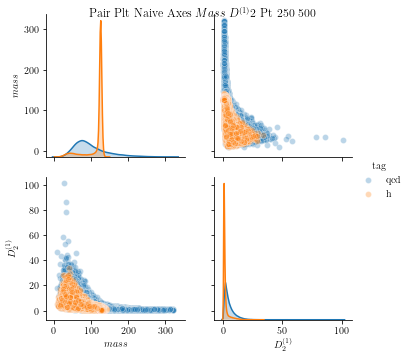

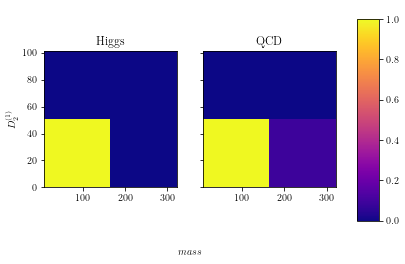

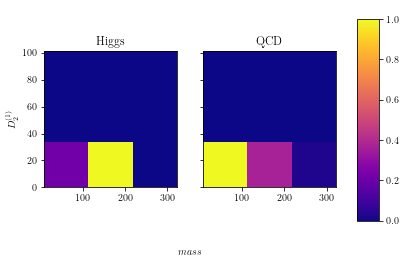

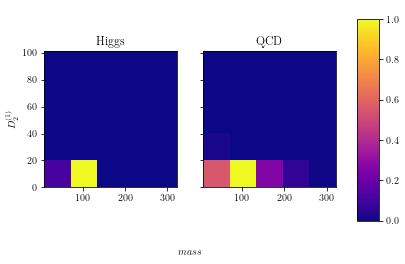

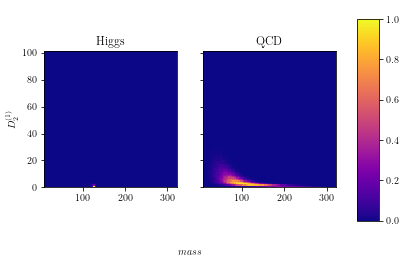

In [31]:
x_label = r'$mass$'
y_label = r'$D^{(1)}_2$'

pair_plt_name = 'pair_plt_naive_axes_{}_{}_pt_{}_{}'.format(x_axis, y_axis, pt_min, pt_max)

pair_plt = sns.pairplot(main_df, hue="tag",
                       plot_kws = {'alpha': 0.3})

replacements = {x_axis : x_label, y_axis : y_label}
for i in range(2):
    for j in range(2):
        curr_x_l = pair_plt.axes[i][j].get_xlabel()
        curr_y_l = pair_plt.axes[i][j].get_ylabel()
        if not i == j:
            pair_plt.axes[i][j].set_alpha(0.5)
        if curr_x_l in replacements.keys():
            pair_plt.axes[i][j].set_xlabel(replacements[curr_x_l])
        if curr_y_l in replacements.keys():
            pair_plt.axes[i][j].set_ylabel(replacements[curr_y_l])


pair_plt_title = pair_plt_name
for k, v in replacements.items():
    pair_plt_title = pair_plt_title.replace(k, v)
pair_plt.fig.suptitle(pair_plt_title.replace("_", " ").title())
pair_plt.savefig(dir_path / Path(pair_plt_name))
plt.show()

n_bins = [2, 3, 5, 100]

min_x = main_df[x_axis].min()
max_x = main_df[x_axis].max()

min_y = main_df[y_axis].min()
max_y = main_df[y_axis].max()

for n_bin in n_bins:
    fig, axes = plt.subplots(nrows=1, ncols=2,
                           sharex=True, sharey=True)

    # Start Higgs Histogram
    fig_h = axes[0]
    
    (hist_h, hist_h_x, hist_h_y) = np.histogram2d(h[x_axis], h[y_axis], bins=n_bin, range=[[min_x, max_x], [min_y, max_y]])
    hist_h = np.transpose(np.divide(hist_h, np.max(hist_h))) # Norm to [0, 1] and transpose
    im = fig_h.imshow(
        hist_h, 
        cmap='plasma', 
        aspect=max_x/max_y, 
        origin='low', 
        extent=[hist_h_x[0], hist_h_x[-1], hist_h_y[0], hist_h_y[-1]]
    )
    fig_h.set_title('Higgs')
    # fig.colorbar(im, ax=fig_h)
    
    # Start QCD Histogram
    fig_qcd = axes[1]
    
    (hist_qcd, hist_qcd_x, hist_qcd_y) = np.histogram2d(qcd[x_axis], qcd[y_axis], bins=n_bin, range=[[min_x, max_x], [min_y, max_y]])
    hist_qcd = np.transpose(np.divide(hist_qcd, np.max(hist_qcd))) # Norm to [0, 1] and transpose
    
    im = fig_qcd.imshow(
        hist_qcd, 
        cmap='plasma', 
        aspect=max_x/max_y, 
        origin='low', 
        extent=[hist_qcd_x[0], hist_qcd_x[-1], hist_qcd_y[0], hist_qcd_y[-1]]
    )
    fig_qcd.set_title('QCD')
    # fig.colorbar(im, ax=fig_qcd)
    
    # Colorbar for both plots
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    fig.add_subplot(111, frameon=False)

    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel(replacements[x_axis])
    plt.ylabel(replacements[y_axis])
    plt.savefig(dir_path / 
                Path('histogram_naive_axis_{}_{}_pt_{}_{}_bin_{}'.format(x_axis, y_axis, pt_min, pt_max, n_bin)))
    plt.show()


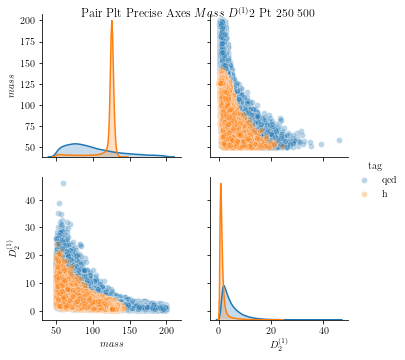

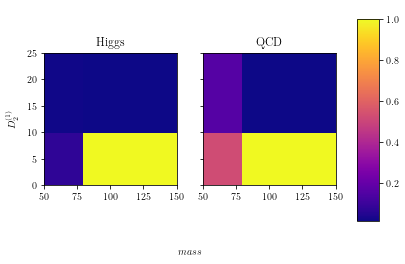

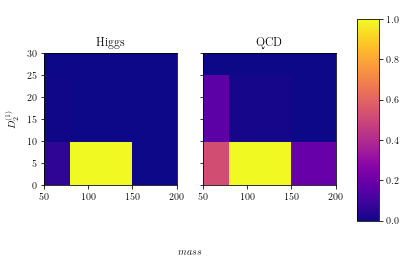

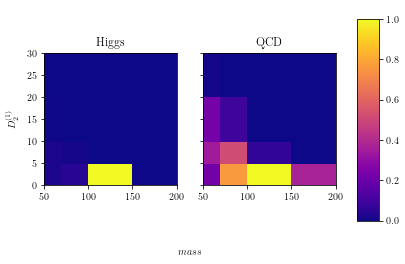

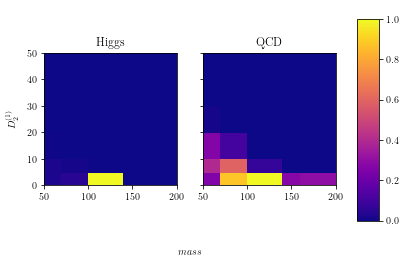

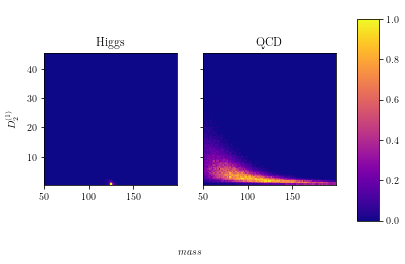

In [36]:
x_label = r'$mass$'
y_label = r'$D^{(1)}_2$'

# Do additional cut on data for nicer plots
d2_min = 0
d2_max = 50
mass_min = 50
mass_max = 200
qcd = qcd[(mass_min < qcd['mass']) & (qcd['mass'] < mass_max) & (d2_min < qcd['d2']) & (qcd['d2'] < d2_max)]
h = h[(mass_min < h['mass']) & (h['mass'] < mass_max) & (d2_min < h['d2']) & (h['d2'] < d2_max)]
main_df = pd.concat([qcd, h])

pair_plt_name = 'pair_plt_precise_axes_{}_{}_pt_{}_{}'.format(x_axis, y_axis, pt_min, pt_max)

pair_plt = sns.pairplot(main_df, hue="tag",
                       plot_kws = {'alpha': 0.3})

replacements = {x_axis : x_label, y_axis : y_label}
for i in range(2):
    for j in range(2):
        curr_x_l = pair_plt.axes[i][j].get_xlabel()
        curr_y_l = pair_plt.axes[i][j].get_ylabel()
        if not i == j:
            pair_plt.axes[i][j].set_alpha(0.5)
        if curr_x_l in replacements.keys():
            pair_plt.axes[i][j].set_xlabel(replacements[curr_x_l])
        if curr_y_l in replacements.keys():
            pair_plt.axes[i][j].set_ylabel(replacements[curr_y_l])


pair_plt_title = pair_plt_name
for k, v in replacements.items():
    pair_plt_title = pair_plt_title.replace(k, v)
pair_plt.fig.suptitle(pair_plt_title.replace("_", " ").title())
pair_plt.savefig(dir_path / Path(pair_plt_name))
plt.show()


min_x = main_df[x_axis].min()
max_x = main_df[x_axis].max()

min_y = main_df[y_axis].min()
max_y = main_df[y_axis].max()

ranges = {
    2: [[50, 80, 150], [0, 10, 25]],
    3: [[50, 80, 150, 200], [0, 10, 25, 30]],
    4: [[50, 70, 100, 150, 200], [0, 5, 10, 20, 30]],
    5: [[50, 70, 100, 140, 160, 200], [0, 5, 10, 20, 30, 50]],
    100: [np.arange(min_x, max_x, (max_x - min_x) / 100.0), np.arange(min_y, max_y, (max_y - min_y) / 100.0)]
}

n_bins = [2, 3, 4, 5, 100]

for n_bin in n_bins:
    # Make grid for histograms to be plotted on
    X, Y = np.meshgrid(ranges[n_bin][0], ranges[n_bin][1])
    
    fig, axes = plt.subplots(nrows=1, ncols=2,
                           sharex=True, sharey=True)

    ## Start Higgs Histogram
    fig_h = axes[0]
    
    # Make normalized histogram, with specific bins, and specific range
    (hist_h, hist_h_x, hist_h_y) = np.histogram2d(
        h[x_axis], h[y_axis], 
        bins=ranges[n_bin], 
        range=[[min_x, max_x], [min_y, max_y]]
    )
    hist_h = np.transpose(np.divide(hist_h, np.max(hist_h))) # Norm to [0, 1] and transpose
    
    # Plot it
    im = fig_h.pcolormesh(
        X, Y, hist_h,
        cmap='plasma'
    )

    # Set aspect ratio to be a square
    fig_h.set_aspect(
        (ranges[n_bin][0][-1] - ranges[n_bin][0][0]) * 1. / (ranges[n_bin][1][-1] - ranges[n_bin][1][0])
    )
    fig_h.set_title('Higgs')
    
    ## Start QCD Histogram
    fig_qcd = axes[1]
    
    # Make normalized histogram, with specific bins, and specific range
    (hist_qcd, hist_qcd_x, hist_qcd_y) = np.histogram2d(
        qcd[x_axis], qcd[y_axis], 
        bins=ranges[n_bin], 
        range=[[min_x, max_x], [min_y, max_y]]
    )
    hist_qcd = np.transpose(np.divide(hist_qcd, np.max(hist_qcd))) # Norm to [0, 1] and transpose
    
    # Plot it
    im = fig_qcd.pcolormesh(
        X, Y, hist_qcd,
        cmap='plasma'
    )

    # Set aspect ratio to be a square
    fig_qcd.set_aspect((ranges[n_bin][0][-1] - ranges[n_bin][0][0]) * 1. / (ranges[n_bin][1][-1] - ranges[n_bin][1][0]))
    fig_qcd.set_title('QCD')
    
    # Colorbar for both plots
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    fig.add_subplot(111, frameon=False)

    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel(replacements[x_axis])
    plt.ylabel(replacements[y_axis])
    plt.savefig(dir_path / 
                Path('histogram_precise_axis_{}_{}_pt_{}_{}_bin_{}'.format(x_axis, y_axis, pt_min, pt_max, n_bin)))
    plt.show()

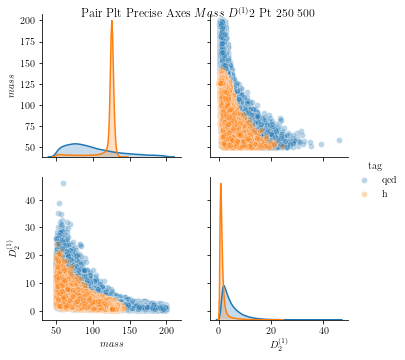

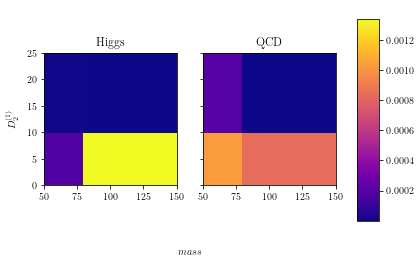

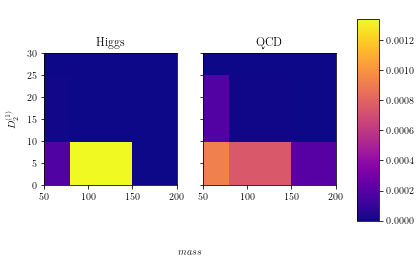

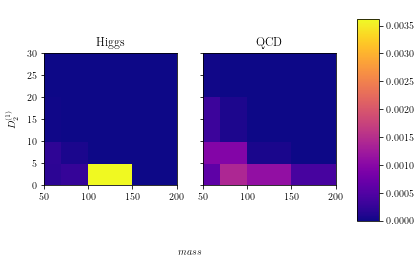

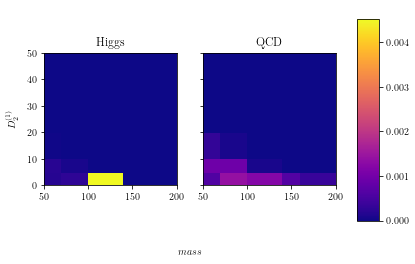

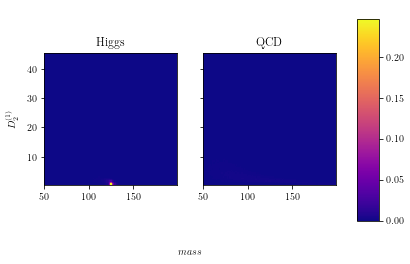

In [35]:
# Depracated
# The differences in Higgs and QCD distributions made code unreadable.
# The code below makes an colorbar consistent with both plots,
# while each one of them in normalized so that sum is = 1.
# This makes plots statistically more rigorous, as color on the left corresponds to color on the right.
# The distributions were unreadable, since max(qcd) << max(h), so histogram for QCD looked like all 0's.

"""
x_label = r'$mass$'
y_label = r'$D^{(1)}_2$'

# Do additional cut on data for nicer plots
d2_min = 0
d2_max = 50
mass_min = 50
mass_max = 200
qcd = qcd[(mass_min < qcd['mass']) & (qcd['mass'] < mass_max) & (d2_min < qcd['d2']) & (qcd['d2'] < d2_max)]
h = h[(mass_min < h['mass']) & (h['mass'] < mass_max) & (d2_min < h['d2']) & (h['d2'] < d2_max)]
main_df = pd.concat([qcd, h])

pair_plt_name = 'pair_plt_precise_axes_{}_{}_pt_{}_{}'.format(x_axis, y_axis, pt_min, pt_max)

pair_plt = sns.pairplot(main_df, hue="tag",
                       plot_kws = {'alpha': 0.3})

replacements = {x_axis : x_label, y_axis : y_label}
for i in range(2):
    for j in range(2):
        curr_x_l = pair_plt.axes[i][j].get_xlabel()
        curr_y_l = pair_plt.axes[i][j].get_ylabel()
        if not i == j:
            pair_plt.axes[i][j].set_alpha(0.5)
        if curr_x_l in replacements.keys():
            pair_plt.axes[i][j].set_xlabel(replacements[curr_x_l])
        if curr_y_l in replacements.keys():
            pair_plt.axes[i][j].set_ylabel(replacements[curr_y_l])


pair_plt_title = pair_plt_name
for k, v in replacements.items():
    pair_plt_title = pair_plt_title.replace(k, v)
pair_plt.fig.suptitle(pair_plt_title.replace("_", " ").title())
pair_plt.savefig(dir_path / Path(pair_plt_name))
plt.show()


min_x = main_df[x_axis].min()
max_x = main_df[x_axis].max()

min_y = main_df[y_axis].min()
max_y = main_df[y_axis].max()

ranges = {
    2: [[50, 80, 150], [0, 10, 25]],
    3: [[50, 80, 150, 200], [0, 10, 25, 30]],
    4: [[50, 70, 100, 150, 200], [0, 5, 10, 20, 30]],
    5: [[50, 70, 100, 140, 160, 200], [0, 5, 10, 20, 30, 50]],
    100: [np.arange(min_x, max_x, (max_x - min_x) / 100.0), np.arange(min_y, max_y, (max_y - min_y) / 100.0)]
}

n_bins = [2, 3, 4, 5, 100]

for n_bin in n_bins:
    # Make grid for histograms to be plotted on
    X, Y = np.meshgrid(ranges[n_bin][0], ranges[n_bin][1])
    
    fig, axes = plt.subplots(nrows=1, ncols=2,
                           sharex=True, sharey=True)

    ## Start Histograms
    # Make both histograms, sum normalized to 1, with specific bins, and specific range
    (hist_h, hist_h_x, hist_h_y) = np.histogram2d(
        h[x_axis], h[y_axis],
        bins=ranges[n_bin],
        range=[[min_x, max_x], [min_y, max_y]],
        density=True
    )
    hist_h = np.transpose(hist_h)
    
    (hist_qcd, hist_qcd_x, hist_qcd_y) = np.histogram2d(
        qcd[x_axis], qcd[y_axis], 
        bins=ranges[n_bin], 
        range=[[min_x, max_x], [min_y, max_y]],
        density=True
    )
    hist_qcd = np.transpose(hist_qcd)

    ## Ploting.
    # Define axes
    fig_h = axes[0]
    fig_qcd = axes[1]
    
    # Choose which figure defines a colorbar on right
    # I assume that both histograms have 0 elements.
    
    if np.max(hist_qcd) > np.max(hist_h): # QCD is bigger
        # Higgs
        fig_h.pcolormesh(
            X, Y, hist_h,
            cmap=truncate_colormap(plt.get_cmap('plasma'), maxval=np.max(hist_h) / np.max(hist_qcd))
        )
        # QCD
        im = fig_qcd.pcolormesh(
            X, Y, hist_qcd,
            cmap='plasma'
        )
    else: # Higgs is bigger
        # Higgs
        im = fig_h.pcolormesh(
            X, Y, hist_h,
            cmap='plasma'
        )
        # QCD
        fig_qcd.pcolormesh(
            X, Y, hist_qcd,
            cmap=truncate_colormap(plt.get_cmap('plasma'), maxval=np.max(hist_qcd) / np.max(hist_h))
        )
    

    # Set aspect ratio to be a square, and set titles
    fig_h.set_aspect(
        (ranges[n_bin][0][-1] - ranges[n_bin][0][0]) * 1. / (ranges[n_bin][1][-1] - ranges[n_bin][1][0])
    )
    fig_h.set_title('Higgs')
    
    fig_qcd.set_aspect((ranges[n_bin][0][-1] - ranges[n_bin][0][0]) * 1. / (ranges[n_bin][1][-1] - ranges[n_bin][1][0]))
    fig_qcd.set_title('QCD')
    
    # Colorbar for both plots
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    fig.add_subplot(111, frameon=False)

    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel(replacements[x_axis])
    plt.ylabel(replacements[y_axis])
    plt.savefig(dir_path / 
                Path('histogram_precise_axis_{}_{}_pt_{}_{}_bin_{}'.format(x_axis, y_axis, pt_min, pt_max, n_bin)))
    plt.show()
"""